# "Multivariate time-series forecasting with Pytorch LSTMs"
> "Using recurrent neural networks for standard tabular time-series problems"

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [python, lstm, pytorch]
- hide: false
- search_exclude: true

Whilst it is all well and good to take one array of data, representing a sequence of values of a function over time, and attempt to predict future values, this often doesn't match the quantity of data available in the real world. More likely, the data we receive will be in tabular form, with each row representing a singular time step. Each row probably consists of several different columns; these are the features, or _predictors_, that we have information about at each time step. One of these columns is not a feature, however. It is the _target_ we want to predict. Consequent

In [1]:
# hide
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Predicting Tesla stock price

### Preprocessing and exploratory analysis

In [50]:
df = pd.read_csv('TSLA.csv', index_col = 'Date', parse_dates=True)
df.drop(columns=['Adj Close'], inplace=True)
df.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2010-06-29,3.800,5.000,3.508,4.778,93831500
2010-06-30,5.158,6.084,4.660,4.766,85935500
2010-07-01,5.000,5.184,4.054,4.392,41094000
2010-07-02,4.600,4.620,3.742,3.840,25699000
2010-07-06,4.000,4.000,3.166,3.222,34334500


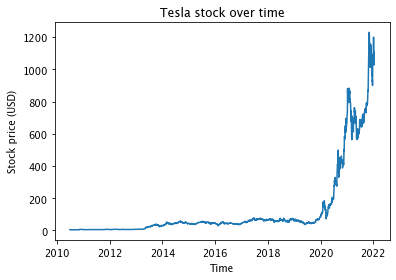

In [51]:
plt.plot(df.Close)
plt.xlabel("Time")
plt.ylabel("Stock price (USD)")
plt.title("Tesla stock over time")
plt.show();

## Setting inputs and outputs

In [52]:
X, y = df.drop(columns=['Close']), df.Close.values
X.shape, y.shape

((2908, 4), (2908,))

In [53]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y.reshape(-1, 1)) 

In [54]:
total_samples = len(df)
train_test_cutoff = round(0.9 * total_samples)

# train-test split (200, 53)
X_train = X_ss[:train_test_cutoff, :]
X_test = X_ss[train_test_cutoff:, :]

y_train = y_mm[:train_test_cutoff, :]
y_test = y_mm[train_test_cutoff:, :] 

In [55]:
print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape) 

Training Shape: (2617, 4) (2617, 1)
Testing Shape: (291, 4) (291, 1)


In [56]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

In [57]:
# convert to pytorch tensors
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

In [58]:
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], 1, 
                                       X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], 1, 
                                      X_test_tensors.shape[1])) 

In [59]:
print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape: torch.Size([2617, 1, 4]) torch.Size([2617, 1])
Testing Shape: torch.Size([291, 1, 4]) torch.Size([291, 1])


In [60]:
X_train

array([[-0.52724312, -0.52222316, -0.52889522,  2.21562311],
       [-0.52139729, -0.51765683, -0.52381251,  1.93547103],
       [-0.52207744, -0.52144806, -0.52648623,  0.3444833 ],
       ...,
       [ 1.22500007,  1.19448911,  1.22778014, -0.41205857],
       [ 1.21673492,  1.19415216,  1.23850144, -0.16130188],
       [ 1.43730973,  1.40288053,  1.36609863,  1.05743414]])

## LSTM model

In [61]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes # number of classes
        self.num_layers = num_layers # number of layers
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # hidden state
        self.seq_length = seq_length # sequence length
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 1
        self.fc = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # internal state
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first Dense
        out = self.relu(out) # relu
        out = self.fc(out) # final Output
        return out

## Training

In [62]:
def training_loop(n_epochs, lstm, optimiser, loss_fn):
    for epoch in range(n_epochs):
        outputs = lstm.forward(X_train_tensors_final) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train_tensors)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        if epoch % 100 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

In [63]:
n_epochs = 1000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = 4 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 1 # number of output classes 

In [64]:
lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers, 
              X_train_tensors_final.shape[1]) # our lstm class

In [65]:
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate) 

In [66]:
training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn)

Epoch: 0, loss: 0.00604
Epoch: 100, loss: 0.00174
Epoch: 200, loss: 0.00016
Epoch: 300, loss: 0.00003
Epoch: 400, loss: 0.00001
Epoch: 500, loss: 0.00001
Epoch: 600, loss: 0.00001
Epoch: 700, loss: 0.00001
Epoch: 800, loss: 0.00001
Epoch: 900, loss: 0.00001


## Prediction

In [71]:
df_X_ss = ss.transform(df.drop(columns=['Close'])) # old transformers
df_y_mm = mm.transform(df.Close.values.reshape(-1, 1)) # old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) # converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

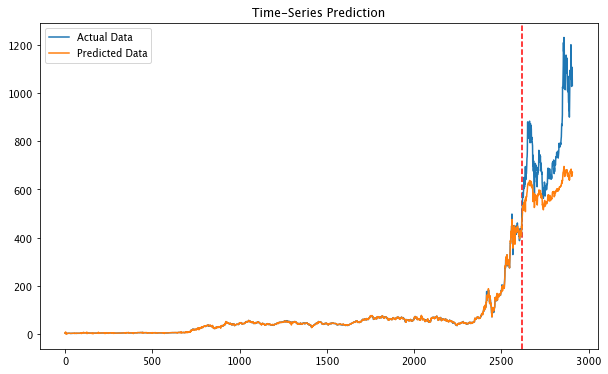

In [73]:
train_predict = lstm(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 